[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/16_generalized_linear_madness.ipynb)

# Chapter 16 - Generalized Linear Madness


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz
    !pip install tensorflow_probability==0.9.0

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 0.25.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

## Tensorflow MCMC Sampling helpers


In [6]:
USE_XLA = False

In [7]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )


class HMCSampler(object):

    @tf.function(autograph=False, experimental_compile=USE_XLA)
    def run_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=NUMBER_OF_BURNIN,
                  ):    

        def _trace_fn_transitioned(_, pkr):
            return (
                pkr.inner_results.inner_results.log_accept_ratio
            )
        
        hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                        target_log_prob_fn,
                        num_leapfrog_steps=num_leapfrog_steps,
                        step_size=step_size)         

        inner_kernel = tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=hmc_kernel,
            bijector=bijectors)       

        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            inner_kernel=inner_kernel,
            target_accept_prob=.8,
            num_adaptation_steps=int(0.8*burnin),
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
        )    

        results, sampler_stat = tfp.mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=burnin,
            current_state=init_state,
            kernel=kernel,
            trace_fn=_trace_fn_transitioned)

        return results, sampler_stat
    
    def sample_from_posterior(jdc, 
                              observed_data, 
                              params, 
                              init_state, 
                              bijectors,                              
                              num_chains=NUMBER_OF_CHAINS,
                              num_samples=NUMBER_OF_SAMPLES, 
                              burnin=NUMBER_OF_BURNIN):       

        
        target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    

        step_size = 0.1
        
        results, sample_stats = HMCSampler.run_chain(init_state,
                                      bijectors,
                                      step_size=step_size,
                                      target_log_prob_fn=target_log_prob_fn,                                      
                                      num_samples=num_samples, 
                                      burnin=burnin)

        stat_names = ['mean_tree_accept']
        sampler_stats = dict(zip(stat_names, [sample_stats]))    
        
        posterior = dict(zip(params, results))

        return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

In [8]:
sample_from_posterior = HMCSampler.sample_from_posterior

## Dataset URLs


In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"

HOWELL1_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
BOXES_DATASET_PATH = f"{_BASE_URL}/Boxes.csv"
PANDA_NUTS_DATASET_PATH = f"{_BASE_URL}/Panda_nuts.csv"
LYNX_HARE_DATASET_PATH = f"{_BASE_URL}/Lynx_Hare.csv"

## Code 16.1

Even though Generalized Linear Models are very powerful, not everything can still be modeled as a GLM - a linear combination of variables mapped onto a non-linear outcome.

Author strongly suggests that starting with GLM instead of real models may have severe consequences as it may be difficult to learn from failures in this case. 

Here the focus is going to be using scientific information in modeling

In [10]:
d = pd.read_csv(HOWELL1_DATASET_PATH, sep=";")

# scale observed variables
d["w"] = d.weight / d.weight.mean()
d["h"] = d.height / d.height.mean()

d

,height,weight,age,male,w,h
0,151.765,47.825606,63.0,1,1.343015,1.097650
1,139.700,36.485807,63.0,0,1.024577,1.010389
2,136.525,31.864838,65.0,0,0.894813,0.987425
3,156.845,53.041915,41.0,1,1.489497,1.134391
4,145.415,41.276872,51.0,0,1.159117,1.051723
...,...,...,...,...,...,...
539,145.415,31.127751,17.0,1,0.874114,1.051723
540,162.560,52.163080,31.0,1,1.464818,1.175725
541,156.210,54.062496,21.0,0,1.518157,1.129798
542,71.120,8.051258,0.0,1,0.226092,0.514380


## Code 16.2

The first thing to notice about the parameters k and p is that they are multiplied in the model and the data have no way to estimate anything except their product



In [11]:
def model_16_1(h):
    def _generator():      
      p = yield Root(tfd.Sample(tfd.Beta(2., 18., name="p"), sample_shape=1))      
      k = yield Root(tfd.Sample(tfd.Exponential(rate=0.5, name="k"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))        
      
      mu = tf.math.log(3.141593 * k * p ** 2 * h ** 3)     
      
      w = yield tfd.Independent(tfd.LogNormal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_16_1 = model_16_1(d["h"])

In [12]:
# TODO - not able to get it working with more than 1 chain
# start to have tensor shape related issues
NUM_CHAINS_FOR_16_1 = 1

# Note - if I use zeros as the starting point
# then the sampled params are really bad
#
# So starting the init state sampled from the model
# itself
p_init, k_init, sigma_init, _ = jdc_16_1.sample()

init_state = [
    p_init,
    k_init,
    sigma_init,
]


bijectors = [
    tfb.Identity(),
    tfb.Exp(),    
    tfb.Exp(),    
]

trace_16_1 = sample_from_posterior(jdc_16_1,
                                   observed_data=(d["w"],),
                                   params=['p', 'k', 'sigma'],
                                   num_chains=NUM_CHAINS_FOR_16_1,
                                   init_state=init_state,
                                   bijectors=bijectors
                                )

## Code 16.3

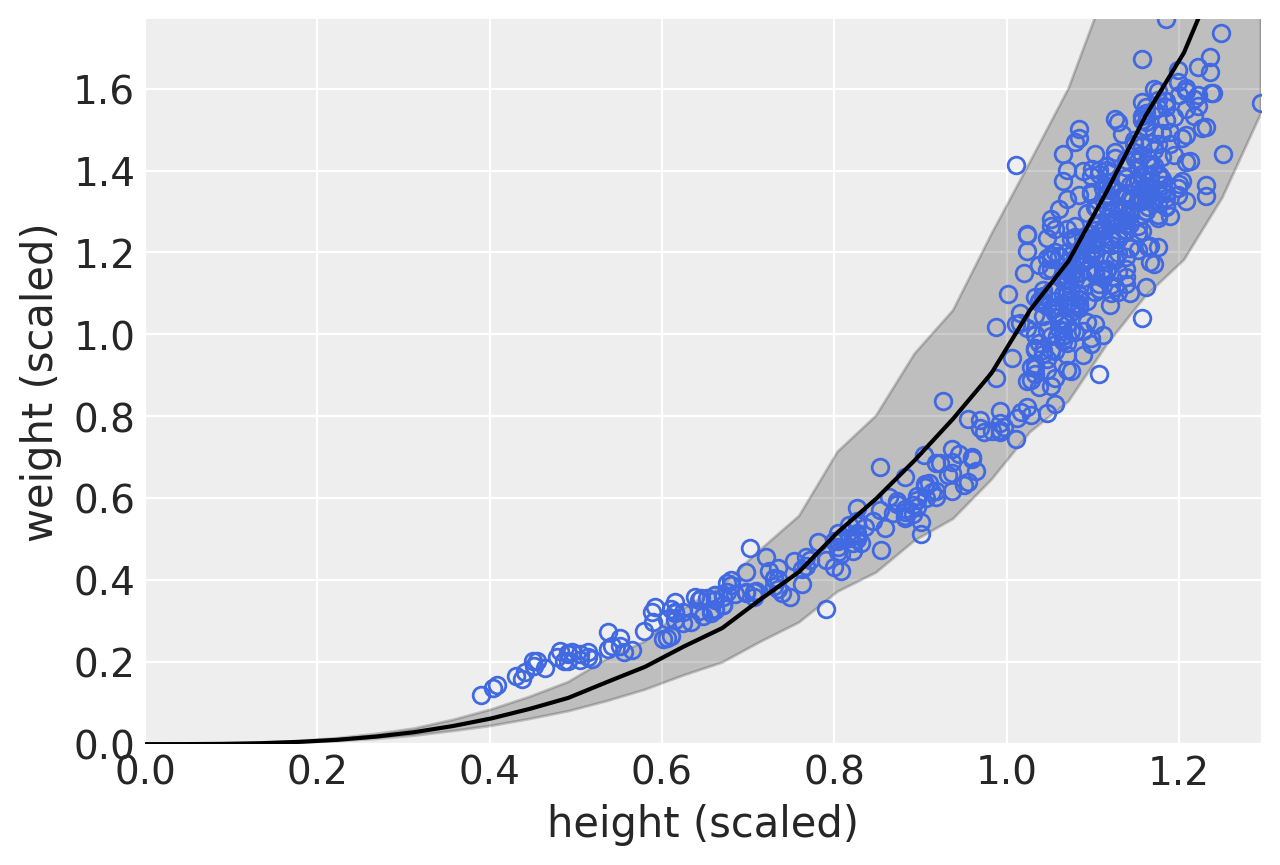

In [13]:
h_seq = np.linspace(0, d.h.max(), num=30)

p_sample = trace_16_1.posterior["p"].values[0]
k_sample = trace_16_1.posterior["k"].values[0]
sigma_sample = trace_16_1.posterior["sigma"].values[0]

def compute_w_from_samples(h):
    mu = tf.math.log(3.141593 * k_sample * p_sample ** 2 * h ** 3)     
    return tfd.LogNormal(loc=mu, scale=sigma_sample).sample().numpy()

w_sim = np.array(list(map(compute_w_from_samples, h_seq))).T

mu_mean = np.mean(w_sim, 0)
w_CI = np.percentile(w_sim, q=(5.5, 94.5), axis=0)

plt.plot(d.h, d.w, "o", c="royalblue", mfc="none")
plt.gca().set(xlim=(0, d.h.max()), ylim=(0, d.w.max()),
              xlabel="height (scaled)", ylabel="weight (scaled)")
plt.plot(h_seq, mu_mean, "k")
plt.fill_between(h_seq, w_CI[0], w_CI[1], color="k", alpha=0.2);

## Code 16.4


This dataset is about choices of the children.

Apparatus has 3 tubes of different colors - Yellow, Blue and Red.

If you drop a ball in the tube then a toy comes out. 

4 children demonstrated how the apparatus works i.e. they dropped the balls in the tube and showed that toys come out. 

629 children were involved aged 4 to 14 years

In each trial, 3 demonstrator children chose the same color and the fourth one chose a differnt color. So out of 3 colors, 1 was selected by majority (i.e. 3 here), 1 was minority and 1 was not selected.

The dataset is about the 5th children's choice once he/she has the seen the demonstration by 4 children. The task is to determine if his/her choice was impacted by the majority.


In [14]:
d = pd.read_csv(BOXES_DATASET_PATH, sep=";")
az.summary(dict(zip(d.columns, d.values.T)))

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 629), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 629), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 629), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 629), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 629), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
y,2.121,0.728,1.0,3.0,0.029,0.021,627.0,627.0,628.0,439.0,NaN
gender,1.506,0.500,1.0,2.0,0.029,0.021,291.0,291.0,291.0,291.0,NaN
age,8.030,2.498,4.0,12.0,0.902,0.671,8.0,8.0,8.0,59.0,NaN
majority_first,0.485,0.500,0.0,1.0,0.018,0.013,797.0,797.0,797.0,628.0,NaN
culture,3.752,1.960,1.0,8.0,1.138,0.900,3.0,3.0,3.0,5.0,NaN


## Code 16.5


1 -> unchosen color by demonstrators

2 -> majority color

3 -> minority color

In [15]:
d.y.value_counts(sort=False) / d.y.shape[0]

1    0.211447
2    0.456280
3    0.332273
Name: y, dtype: float64

Above shows, that majority color was indeed chosen by the fifth children. But does this mean it was simply because of demonstration ? Was it the **cause** of what we are seeing in the data ?

Authors says that we can not be sure of it because there could be different strategies and it may be the case that one of the strategy led to the same choice

## Code 16.6

If we simulate choices for these children, we can figure out how often we might see the “2” choice, the one that indicates the majority color.

In [16]:
N = 30  # number of children

# half are random
# sample from 1,2,3 at random for each
y1 = np.array([1, 2, 3])[
    tfd.Sample(tfd.Categorical(logits=np.ones(3)), sample_shape=(N // 2,)).sample().numpy()
]

# half follow majority
y2 = np.repeat(2, N // 2)

# combine
y = np.concatenate([y1, y2])

# shuffle
np.random.shuffle(y)

# count the 2s
print(np.sum(y == 2) / N)

0.6666666666666666


About 2/3rd of the choices are for the majority color (i.e. 2)

## Code 16.7  (Not working !)

Having issues with shape again :(

In [17]:
d.describe()

,y,gender,age,majority_first,culture
count,629.000000,629.000000,629.000000,629.000000,629.000000
mean,2.120827,1.505564,8.030207,0.484897,3.751987
std,0.727986,0.500367,2.497906,0.500170,1.960319
min,1.000000,1.000000,4.000000,0.000000,1.000000
25%,2.000000,1.000000,6.000000,0.000000,3.000000
50%,2.000000,2.000000,8.000000,0.000000,3.000000
75%,3.000000,2.000000,10.000000,1.000000,5.000000
max,3.000000,2.000000,14.000000,1.000000,8.000000


In [18]:
def make_boxes_model(N, y, majority_first):
    def _generator():
        # prior
        p = yield Root(tfd.Sample(tfd.Dirichlet(tf.cast(np.repeat(4, 5), dtype=tf.float32)), sample_shape=1))
        
        # probability of data
        phi = [None] * 5
        phi[0] = np.where(y == 2, 1, 0)  # majority
        phi[1] = np.where(y == 3, 1, 0)  # minority
        phi[2] = np.where(y == 1, 1, 0)  # maverick
        phi[3] = np.repeat(1.0 / 3.0, N) # random
        phi[4] = np.where(majority_first == 1,  # follow first
                          np.where(y == 2, 1, 0),
                          np.where(y == 3, 1, 0))
        
#         ps = tf.squeeze(p)
        ps = p
        phi = np.array(phi, dtype=np.float32)
        
        print(ps.shape)
        print(phi.shape)
        
        # compute log( p_s * Pr(y_i|s )
        for j in range(5):
            phi[j] = tf.math.log(ps[j]) + tf.math.log(phi[j])
            
        # compute average log-probability of y
        logprob = tf.math.reduce_logsumexp(tf.stack(tf.constant(phi), axis=1), axis=1)
        
        w = yield tfd.Independent(tfd.Deterministic(loc=logprob), reinterpreted_batch_ndims=1) 
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

In [19]:
dat= dict(N=d.shape[0],
          y=d.y.values,
          majority_first=d.majority_first.values)

jdc_boxes_model = make_boxes_model(dat["N"], dat["y"], dat["majority_first"])


In [21]:
# uncomment the line below to see the error

#jdc_boxes_model.sample(2)

## Code 16.8 (depends on 16.7) [Not implemented]

## Code 16.9

Modelling nut opening skill of chimpanzees

In [22]:
d = pd.read_csv(PANDA_NUTS_DATASET_PATH, sep=";")
d


,chimpanzee,age,sex,hammer,nuts_opened,seconds,help
0,11,3,m,G,0,61.0,N
1,11,3,m,G,0,37.0,N
2,18,4,f,wood,0,20.0,N
3,18,4,f,G,0,14.0,y
4,18,4,f,L,0,13.0,N
...,...,...,...,...,...,...,...
79,10,15,m,G,7,12.0,N
80,10,15,m,G,5,12.5,N
81,6,15,m,G,8,13.0,N
82,6,16,m,G,24,20.0,N


We want to understand how nut opening skills develop and which factors contribute to it. 

We need a generative model of nut opening rate as it varies by age.

On simple factor to assume is the individual's strenght and as age increases it increases as well.

## Code 16.10

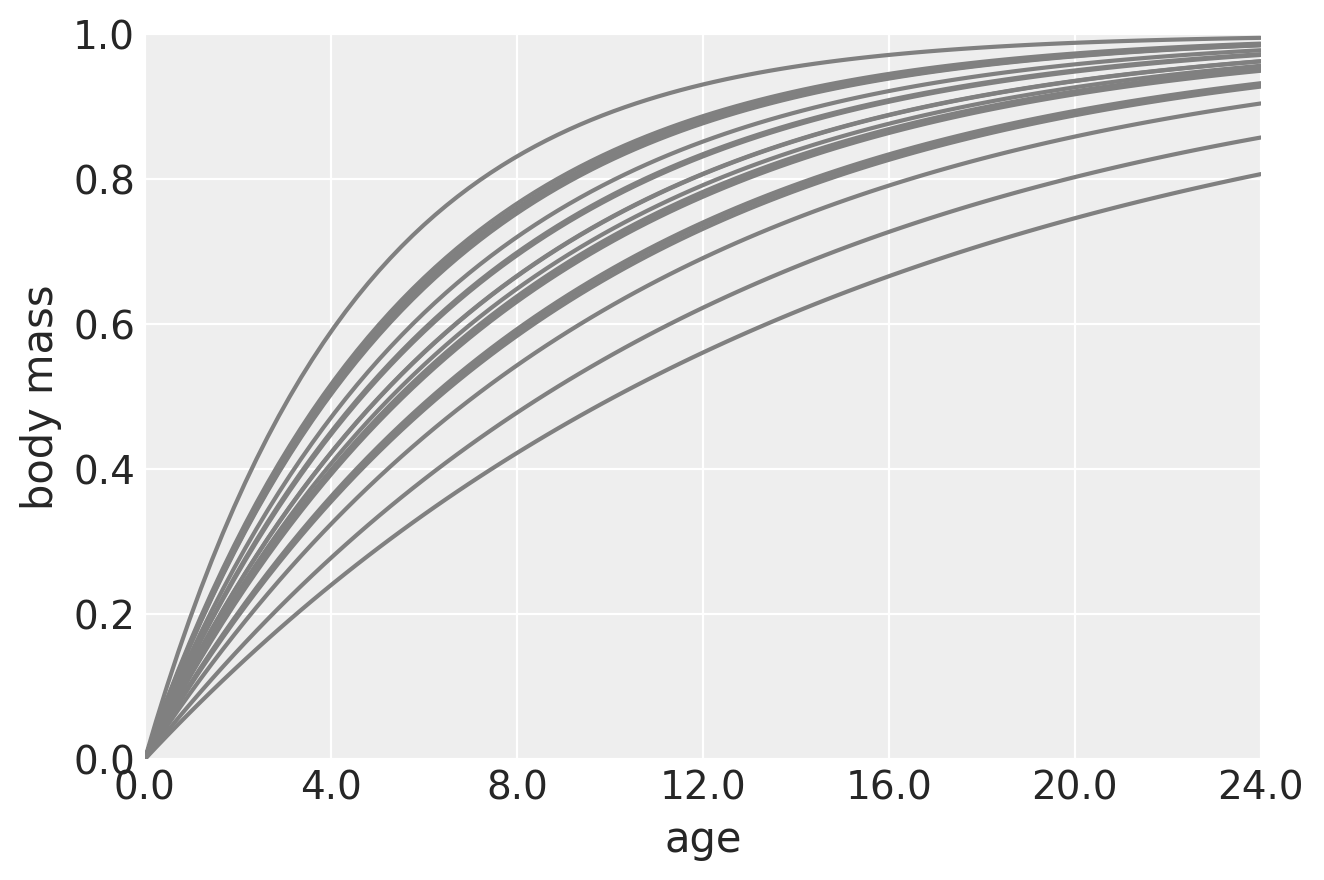

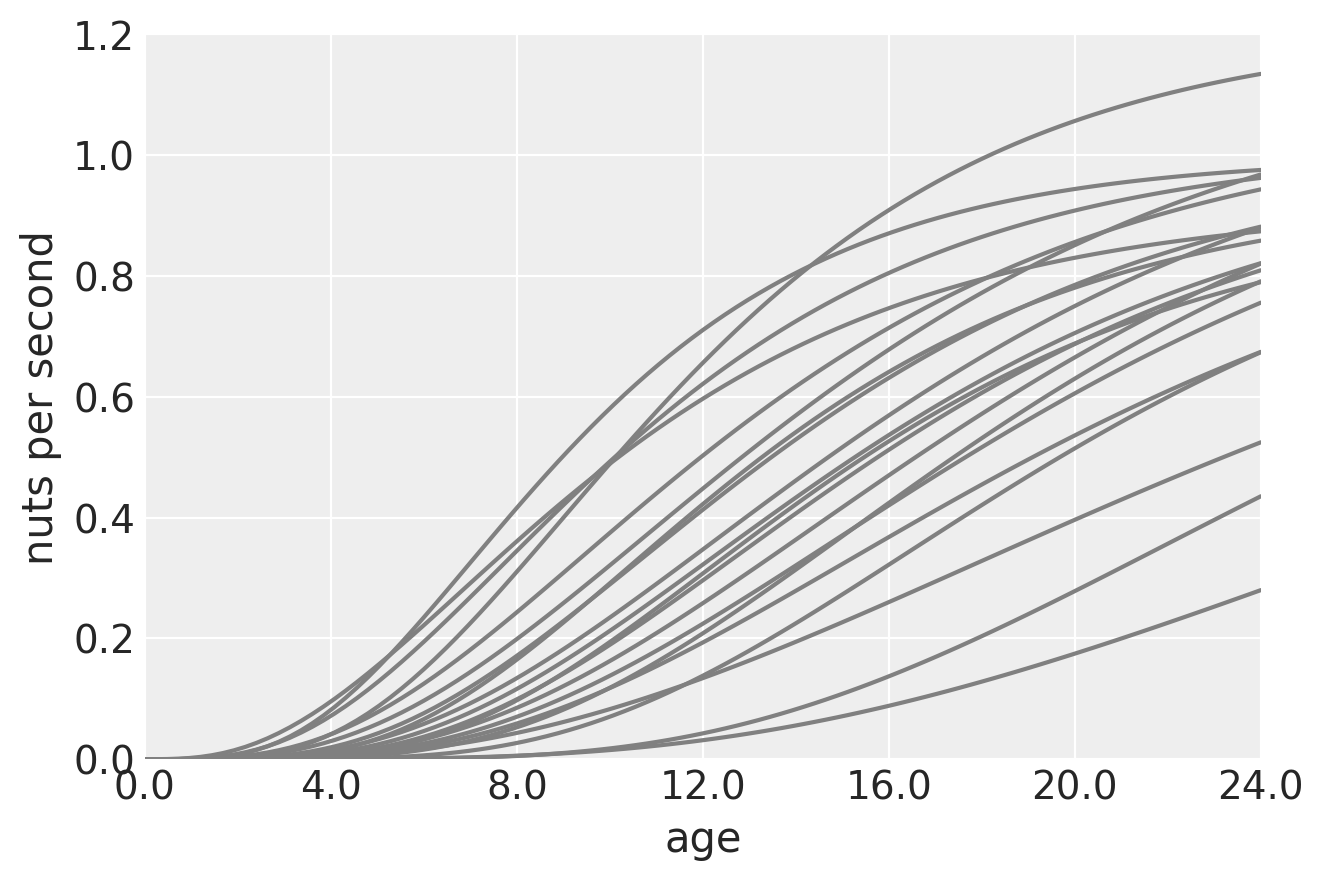

In [28]:
N = int(1e4)
phi = tfd.LogNormal(np.log(1), 0.1).sample((N,)).numpy()
k = tfd.LogNormal(np.log(2), 0.25).sample((N,)).numpy()
theta = tfd.LogNormal(np.log(5), 0.25).sample((N,)).numpy()

# relative grow curve
ax = plt.subplot(xlim=(0, 1.5), ylim=(0, 1), xlabel="age", ylabel="body mass")
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=np.round(at * d.age.max()))
x = np.linspace(0, 1.5, 101)
for i in range(20):
    plt.plot(x, 1 - np.exp(-k[i] * x), "gray", lw=1.5)
plt.show()

# implied rate of nut opening curve
ax = plt.subplot(xlim=(0, 1.5), ylim=(0, 1.2), xlabel="age",
                 ylabel="nuts per second")
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=np.round(at * d.age.max()))
x = np.linspace(0, 1.5, 101)
for i in range(20):
    plt.plot(x, phi[i] * (1 - np.exp(-k[i] * x)) ** theta[i], "gray", lw=1.5)


The first graph (body mass vs age) is showing that opening kill tries to start leveling off around age 12

The second graph (nuts per second vs age) shows many different developmental patterns

## Code 16.11

In [53]:
dat = dict(n=d.nuts_opened.values,
           age=tf.cast(d.age.values / d.age.max(), dtype=tf.float32),
           seconds=tf.cast(d.seconds.values, dtype=tf.float32))

def model_16_4(seconds, age):
    def _generator():      
      phi = yield Root(tfd.Sample(tfd.LogNormal(tf.math.log(1.), 0.1, name="phi"), sample_shape=1))      
      k = yield Root(tfd.Sample(tfd.LogNormal(tf.math.log(2.), 0.25, name="k"), sample_shape=1))      
      theta = yield Root(tfd.Sample(tfd.LogNormal(tf.math.log(5.), 0.25, name="theta"), sample_shape=1))      
    
      lambda_ = seconds * phi * (1 - tf.exp(-k*age)) ** theta 
      
      n = yield tfd.Independent(tfd.Poisson(lambda_), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_16_4 = model_16_4(dat["seconds"], dat["age"])

In [56]:
# TODO - not able to get it working with more than 1 chain
# start to have tensor shape related issues
NUM_CHAINS_FOR_16_4 = 1

# Note - if I use zeros as the starting point
# then the sampled params are really bad
#
# So starting the init state sampled from the model
# itself
phi_init, k_init, theta_init, _ = jdc_16_4.sample()

init_state = [
    phi_init,
    k_init,
    theta_init,
]


bijectors = [
    tfb.Identity(),
    tfb.Identity(),    
    tfb.Identity(),    
]

trace_16_4 = sample_from_posterior(jdc_16_4,
                                   observed_data=(dat["n"],),
                                   params=['phi', 'k', 'theta'],
                                   num_chains=NUM_CHAINS_FOR_16_4,
                                   init_state=init_state,
                                   bijectors=bijectors
                                )

## Code 16.12

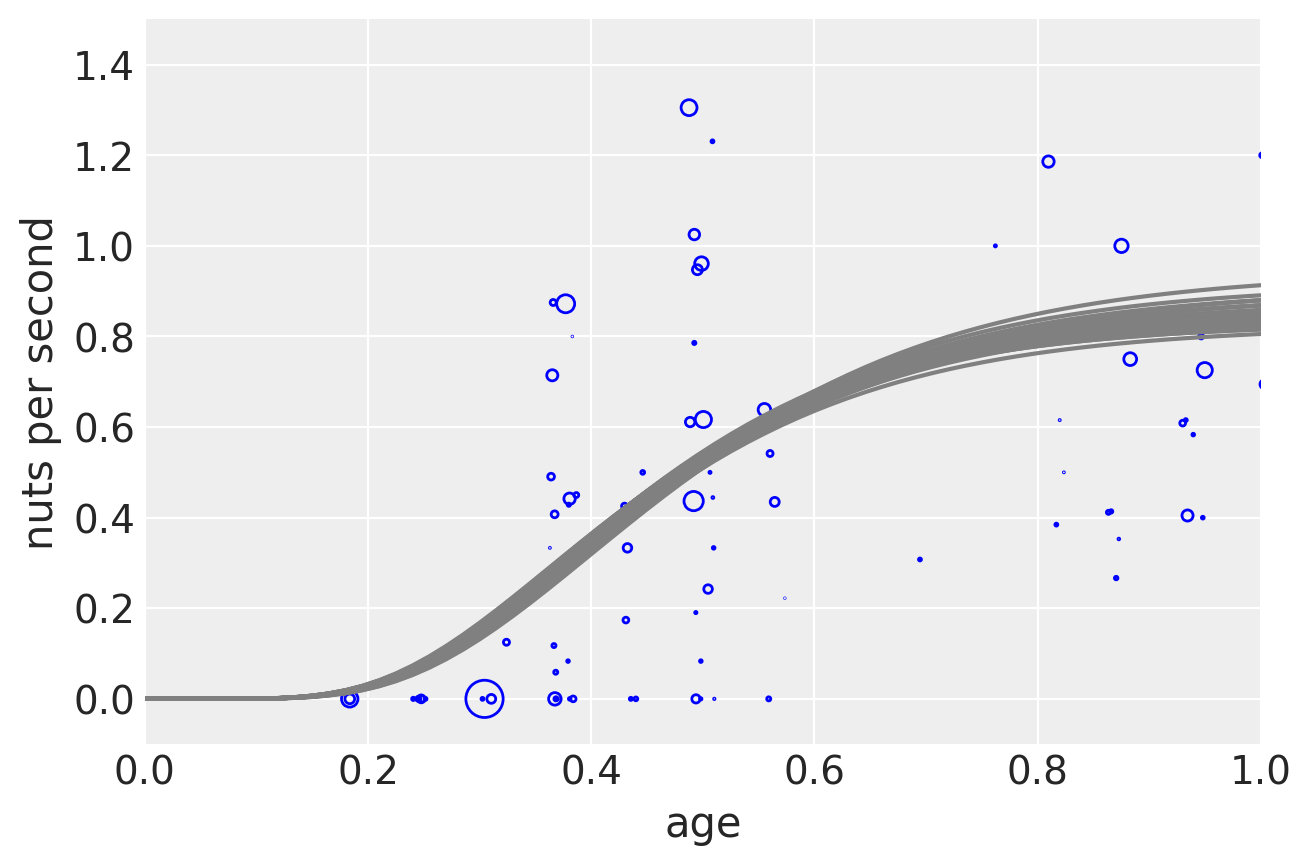

In [57]:
post_phi = trace_16_4.posterior["phi"].values[0]
post_k   = trace_16_4.posterior["k"].values[0]
post_theta  = trace_16_4.posterior["theta"].values[0]

plt.subplot(xlim=(0, 1), ylim=(-0.1, 1.5), xlabel="age",
            ylabel="nuts per second")
at = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set(xticks=at, xticklabels=np.round(at * d.age.max()))

# raw data
pts = dat["n"] / dat["seconds"]
normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
point_size = normalize(dat["seconds"])
eps = (dat["age"][1:] - dat["age"][:-1]).numpy().max() / 5
jitter = eps * tfd.Uniform(low=-1, high=1).sample(dat["age"].shape)
plt.scatter(dat["age"] + jitter, pts, s=(point_size * 3) ** 2 * 20,
            color="b", facecolors="none")

# 30 posterior curves
x = np.linspace(0, 1.5, 101)
for i in range(30):
    plt.plot(
        x,
        post_phi[i] * (1 - np.exp(-post_k[i] * x)) ** post_theta[i], "gray")